# Lab Instructions

You have been hired by James Cameron to create profiles of two characters for a reboot of the Titanic Movie: one that is most likely to survive the sinking and one that is least likely to survive.  Mr. Cameron wants this reboot to be as historically accurate as possible, so your profile of each character should be backed up with data and visualizations.

Each character profile should include information on their:
* Age, fare
* Sex
* Passenger class
* Travel companions (including both parents/children and siblings/spouse)
* Port of departure (indicated by the Embarked feature in the dataset)

For quantitative features like `Age` and `Fare`, you will need to use the `.loc` method we learned in class (or something similar) to place individuals in categories.  How you choose to do this is up to you, but make sure you explain your reasoning.

You should include at least one visualization for each element of the character profile (age, sex, passenger class, etc.) as evidence.

After you have developed your two character profiles, use your Pandas data wrangling skills to identify at least one real passenger in the dataset that fits each profile.  Print out the names of these individuals.  Look them up in [Encyclopeida Titanica](https://www.encyclopedia-titanica.org/) (or a similar resource).  

Tell Mr. Cameron at least one thing about the real passengers who fit your two character profiles that you learned from an external resource.  You need one interesting fact about a person who fits the profile of "most likely to survive" and one interesting fact about a person who fits the profile of "least likely to surivive".  



In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('titanic_passengers.csv')
df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

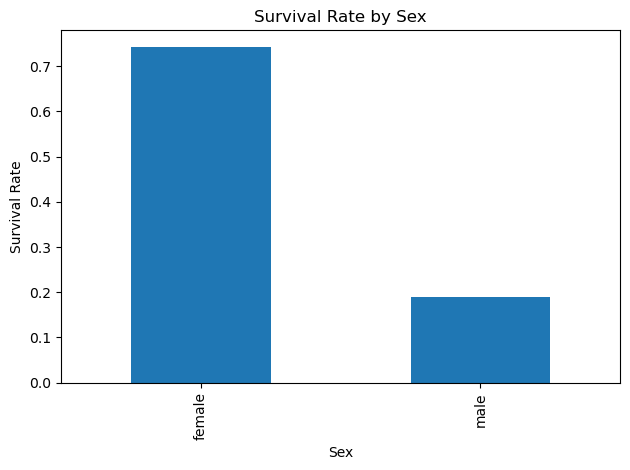

In [20]:
df["FamilySize"] = df["SibSp"] + df["Parch"]

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # silencing future warnings for cleaner presentation

bins = [0, 12, 18, 30, 50, 100]
labels = ["Child", "Teen", "Young Adult", "Adult", "Senior"]
df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels)

df["FareGroup"] = pd.qcut(df["Fare"], 4, labels=["Low", "Medium", "High", "Very High"])

def fam_cat(n):
    if n == 0:
        return "Alone"
    elif n <= 3:
        return "Small (1–3)"
    elif n <= 6:
        return "Medium (4–6)"
    else:
        return "Large (7+)"
        
df["FamilyCategory"] = df["FamilySize"].apply(fam_cat)

def plot_survival_by(col, title):
    df.groupby(col)["Survived"].mean().plot(kind="bar", title=title)
    plt.ylabel("Survival Rate")
    plt.tight_layout()
    plt.show()

plot_survival_by("Sex", "Survival Rate by Sex")


### Conclusion
The most likely to survive would be female, while the least likely would be male.


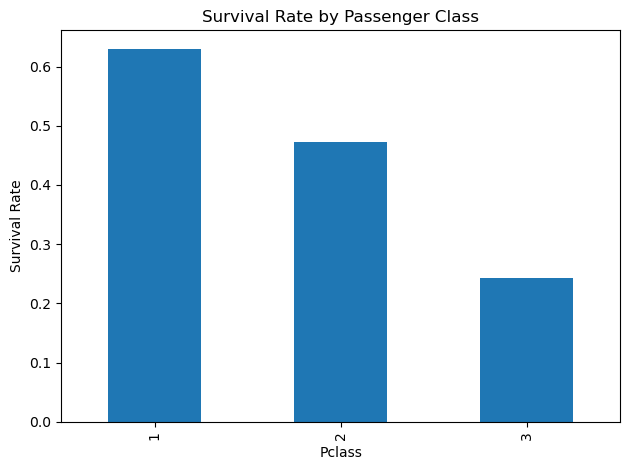

In [19]:
plot_survival_by("Pclass", "Survival Rate by Passenger Class")


### Conclusion
The most likely to survive is from the upper class (1), with the lowest class passenger being the least likely to survive. Just more proof it pays to be rich...

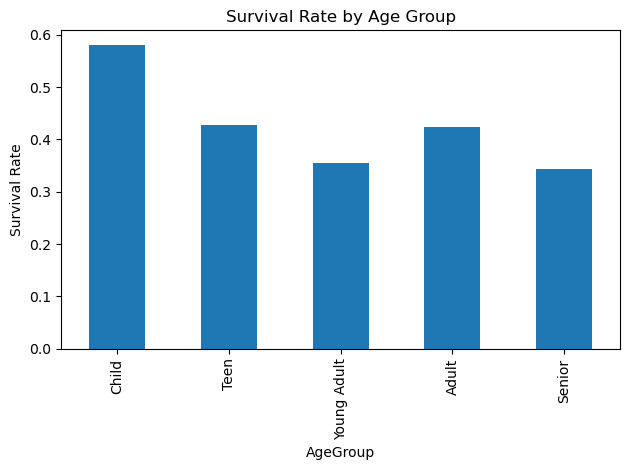

In [21]:
plot_survival_by("AgeGroup", "Survival Rate by Age Group")


### Conclusion
As long as you weren't a senior citizen or young adult, you had the best shot at survival. This makes sense since the old have already lived their lives and the young adults don't have anyone relying on them.

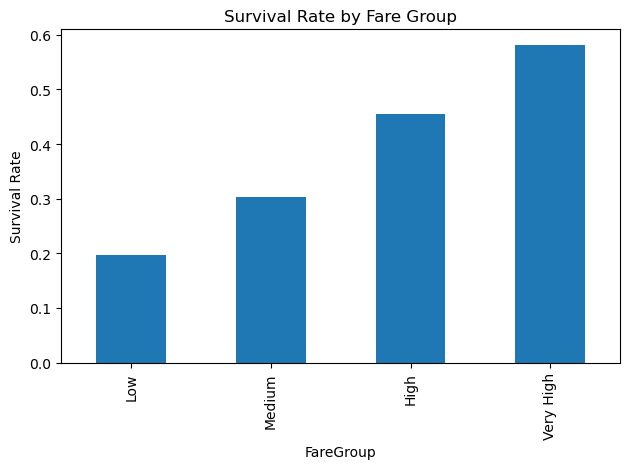

In [22]:
plot_survival_by("FareGroup", "Survival Rate by Fare Group")


### Conclusion
Once again, money is a factor. The "Very High" category would be the first class tickets, ensuring a greater chance of survival

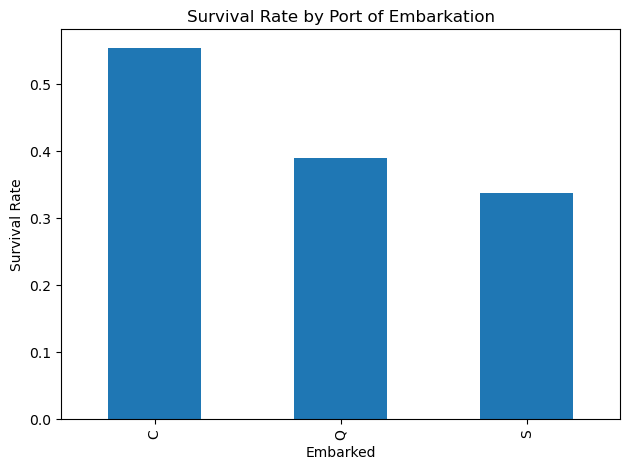

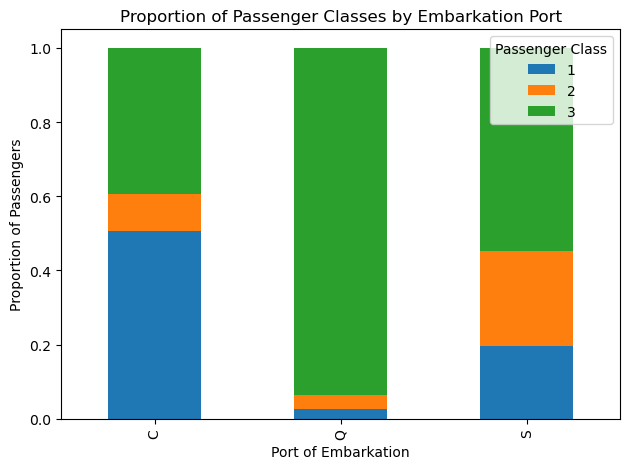

In [30]:
plot_survival_by("Embarked", "Survival Rate by Port of Embarkation")
# Group by embarkation port and passenger class
embark_class = df.groupby(["Embarked", "Pclass"]).size().unstack()

# Normalized proportions per embarkation point
embark_class_norm = embark_class.div(embark_class.sum(axis=1), axis=0)

# Plot
embark_class_norm.plot(kind="bar", stacked=True)
plt.title("Proportion of Passenger Classes by Embarkation Port")
plt.xlabel("Port of Embarkation")
plt.ylabel("Proportion of Passengers")
plt.legend(title="Passenger Class")
plt.tight_layout()
plt.show()

### Conclusion
The above 2 plots work in conjunction with each other. With the most first class passengers embarking at Cherbourg, France, it makes since this point would have the most survivors.

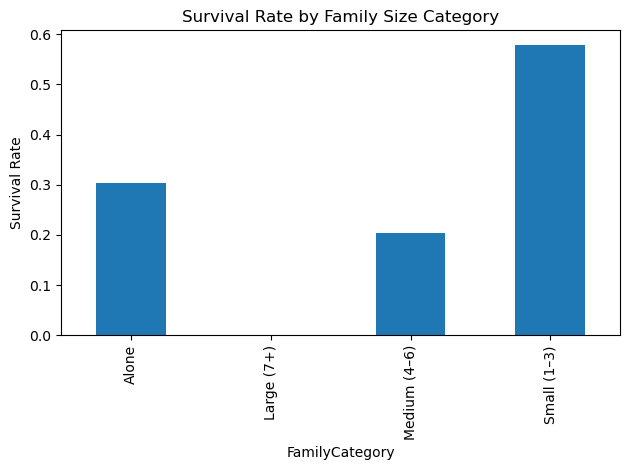

Number of passengers in large families: 62
Number of distinct large families (by surname): 14


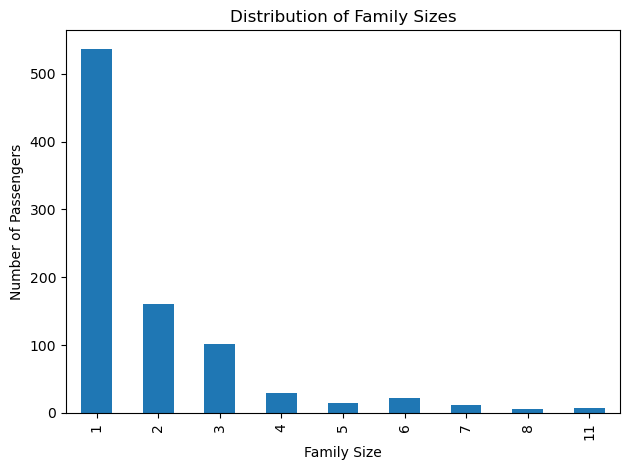

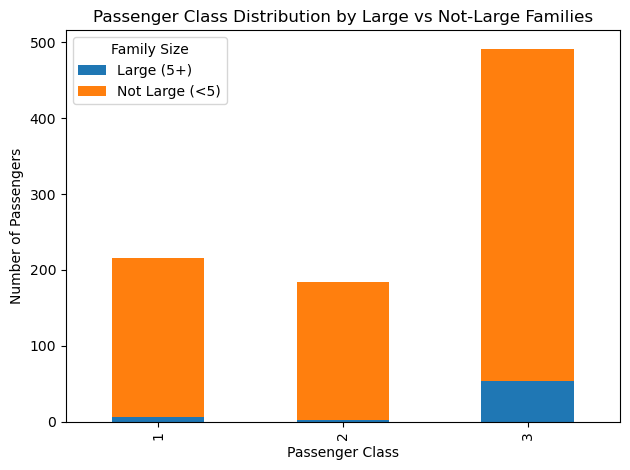

In [33]:
plot_survival_by("FamilyCategory", "Survival Rate by Family Size Category")

# Create a new column for total family size (siblings/spouses + parents/children + self)
df["family_size"] = df["SibSp"] + df["Parch"] + 1

# Define what “large” means — let’s say 5 or more people
large_families = df[df["family_size"] >= 5]

# Count how many passengers belong to large families
num_large_families = large_families["family_size"].count()

# Count how many *distinct families* that represents (by last name, roughly)
large_family_names = large_families["Name"].apply(lambda x: x.split(",")[0].strip())
num_distinct_large_families = large_family_names.nunique()

print(f"Number of passengers in large families: {num_large_families}")
print(f"Number of distinct large families (by surname): {num_distinct_large_families}")

# Optional: see how large families were distributed by size
df["family_size"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Family Sizes")
plt.xlabel("Family Size")
plt.ylabel("Number of Passengers")
plt.tight_layout()
plt.show()

# Add a column categorizing families as Large or Not Large
df["FamilyCategorySimple"] = df["family_size"].apply(lambda x: "Large (5+)" if x >= 5 else "Not Large (<5)")

# Group by class and family category
class_family = df.groupby(["Pclass", "FamilyCategorySimple"]).size().unstack()

# Plot stacked bar chart (counts)
class_family.plot(kind="bar", stacked=True)
plt.title("Passenger Class Distribution by Large vs Not-Large Families")
plt.xlabel("Passenger Class")
plt.ylabel("Number of Passengers")
plt.legend(title="Family Size")
plt.tight_layout()
plt.show()

### Conclusion
These three plots paint maybe the saddest picture of all. There was not a single large family (7+ members) who had everyone survive. Entire families were wiped out in one fell swoop. It makes since that there were a greater number of large families in 3rd class, as it was the best, if not only, way for most families to ensure everyone was able to travel.


# Most likely to survive

In [25]:
most_likely = df.loc[
    (df["Sex"] == "female") &
    (df["Pclass"] == 1) &
    (df["Age"] >= 20) & (df["Age"] <= 40) &
    (df["FareGroup"].isin(["High", "Very High"])) &
    (df["FamilyCategory"] == "Small (1–3)") &
    (df["Embarked"] == "C")
]

print("\n--- Most Likely to Survive Candidates ---")
print(most_likely[["Name", "Sex", "Age", "Pclass", "Fare", "FamilySize", "Embarked", "Survived"]].head(5))


--- Most Likely to Survive Candidates ---
                                                  Name     Sex   Age  Pclass  \
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0       1   
215                            Newell, Miss. Madeleine  female  31.0       1   
319  Spedden, Mrs. Frederic Oakley (Margaretta Corn...  female  40.0       1   
393                             Newell, Miss. Marjorie  female  23.0       1   
539                 Frolicher, Miss. Hedwig Margaritha  female  22.0       1   

         Fare  FamilySize Embarked  Survived  
1     71.2833           1        C         1  
215  113.2750           1        C         1  
319  134.5000           2        C         1  
393  113.2750           1        C         1  
539   49.5000           2        C         1  


# Least likely to survive

In [26]:
least_likely = df.loc[
    (df["Sex"] == "male") &
    (df["Pclass"] == 3) &
    (df["Age"] >= 20) & (df["Age"] <= 40) &
    (df["FareGroup"] == "Low") &
    (df["FamilyCategory"].isin(["Alone", "Large (7+)"])) &
    (df["Embarked"] == "S")
]

print("\n--- Least Likely to Survive Candidates ---")
print(least_likely[["Name", "Sex", "Age", "Pclass", "Fare", "FamilySize", "Embarked", "Survived"]].head(5))


--- Least Likely to Survive Candidates ---
                             Name   Sex   Age  Pclass    Fare  FamilySize  \
51   Nosworthy, Mr. Richard Cater  male  21.0       3  7.8000           0   
75        Moen, Mr. Sigurd Hansen  male  25.0       3  7.6500           0   
91     Andreasson, Mr. Paul Edvin  male  20.0       3  7.8542           0   
105         Mionoff, Mr. Stoytcho  male  28.0       3  7.8958           0   
108               Rekic, Mr. Tido  male  38.0       3  7.8958           0   

    Embarked  Survived  
51         S         0  
75         S         0  
91         S         0  
105        S         0  
108        S         0  


In [27]:
print("\nNames to research on Encyclopedia Titanica:")
print("\nMost likely to survive:")
print(most_likely["Name"].head(1).to_string(index=False))
print("\nLeast likely to survive:")
print(least_likely["Name"].head(1).to_string(index=False))


Names to research on Encyclopedia Titanica:

Most likely to survive:
Cumings, Mrs. John Bradley (Florence Briggs Tha...

Least likely to survive:
Nosworthy, Mr. Richard Cater


# Facts
from Encylopedia Titanica


### Mrs. John Bradley (Florence Briggs) Cumings (Most likely to survive)
Born December 31, 1873, Mrs. Cumings married John Bradley Cumings, a banker and stockbroker, who was a partner at Cumings & Marckwald on Wall Street. Originally from Boston, they had 2 children before moving to Manhattan around 1900.

### Mr. Richard Cater Nosworthy (Least likely to survive)
Born in Devon, England on April 3, 1891, son of George and Lavinia Nosworthy. Originally booked passage on the Olympic, but due to train delays, his journey to Southampton ended in Exeter. He transferred his passage to the Titanic. Was traveling to either Buffalo, New York (Go Bills!) or Canada, depending on reports.



Number of passengers in large families: 62
Number of distinct large families (by surname): 14


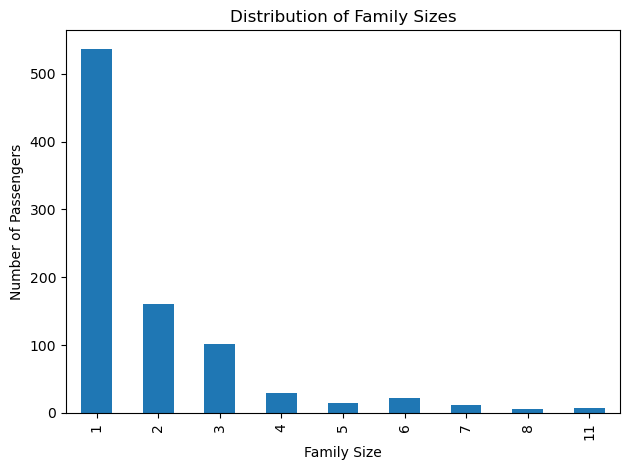